In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
import seaborn as sns
from PMTK.sampling.preferences_sampler import *
from PMTK.pref.preferences import *
from PMTK.utility.utility_solver import *
from PMTK.sampling.subset_samplers import *
from PMTK.utility.model_solver import *
from PMTK.utility.subset_finder import *
from PMTK.sampling.gibbs import *
from PMTK.data.film_dataset import *
from PMTK.sampling.decider import *

In [4]:
def check_connivence_resolution(connivent_set, candidate):
    if len(candidate) == 0:
        return False
    c = 0
    for x,y in connivent_set:
        if all(i in x for i in candidate):
            c += 1
        if all(i in y for i in candidate):
            c -= 1
    return c != 0


In [5]:
n_items = 6
density = 0.2
items = np.arange(n_items)
prf = sample_preferences_from_order(items, density*(2**(n_items+1)), indifference_rate= 0)

In [12]:
def build_approx_theta(prf, init_theta = None):
    connivents = []
    if not init_theta:
        init_theta = [EMPTY_SET]
    theta = init_theta
    min_k = 1
    c  = get_connivent(theta, prf)
    while c:
        if not c in connivents:
            connivents.append(c)
        cit = get_candidate_iterator(c)
        skey = sorted(cit.keys())[0]
        b = False
        for k in cit:
            if b:
                break
            for i in cit[k]:
                for t in i:
                    b = False or check_connivence_resolution(c, t)
                    if not t in theta and check_connivence_resolution(c, t):
                        theta.append(t)
        c  = get_connivent(theta, prf)
    a = additivity(theta)
    for c in connivents:
        cit = get_candidate_iterator(c)
        for k in cit:
            if k > a:
                break
            for i in cit[k]:
                for t in i:
                    if not t in theta and check_connivence_resolution(c,t):
                        theta.append(t)
    
    return theta

In [17]:
data = {
    "n_pref":[],
    "n_items":[],
    "method":[],
    "MSS":[]
}
n_items = 5
for d in tqdm(np.linspace(0.1,0.3,50)):
    for _ in range(10):
        items = np.arange(n_items)
        prf = sample_preferences_from_order(items, d*(2**(n_items+1)), indifference_rate= 0)
        theta = build_approx_theta(prf)
        
        t2 = get_kernels(prf, theta)
        data["n_pref"].append(len(prf))
        data["n_items"].append(n_items)
        data["method"].append("LEX")
        data["MSS"].append(len(t2))
        
        t = get_kernels_opt(prf, theta)
        data["n_pref"].append(len(prf))
        data["n_items"].append(n_items)
        data["method"].append("LEX+")
        data["MSS"].append(len(t))
        df = pd.DataFrame(data)
        df.to_csv("kernel_stats.csv")
    

 90%|███████████████████████████████████████████████████████████████▉       | 45/50 [03:43<00:24,  4.97s/it]


Exception: Empty Polyhedron

<AxesSubplot:xlabel='n_pref', ylabel='MSS'>

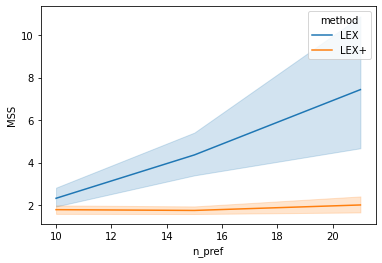

In [18]:
sns.lineplot(x = "n_pref", y = "MSS",hue = "method",  data = df) 